In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping

# On va chercher les données dans le fichier CSV
data = pd.read_csv('./data/train.csv')

labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# On va séparer les données en deux parties : les commentaires et les labels
X = data['comment_text']
y = data[labels]

# On va séparer les données en deux parties : une pour l'entraînement et une pour le test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# On définit les paramètres, max_words est le nombre de mots maximum que l'on va garder, max_len est la longueur maximale d'un commentaire.
max_words = 20000
max_len = 30

# Ici le tokenizer va transformer les commentaires en séquences de nombres.
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# On va ajouter des 0 pour que toutes les séquences aient la même longueur.
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# On va utiliser un algorithme de sous-échantillonnage pour équilibrer les classes.
X_resampled_list = []
y_resampled_list = []

for label in labels:
  X_res, y_res = RandomUnderSampler().fit_resample(X_train_pad, y_train[label])
  X_resampled_list.append(X_res)
  y_resampled_list.append(y_res)
  
X_resampled = np.concatenate(X_resampled_list, axis=0)
y_resampled = np.concatenate(y_resampled_list, axis=0)

# On crée un modèle avec une couche d'embedding, une couche de LSTM et une couche dense.
model = Sequential()
model.add(Embedding(max_words, 50, input_length=max_len, input_shape=(X_resampled.shape[1],)))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# On compile le modèle avec une loss binary_crossentropy, un optimizer adam et une métrique accuracy.
# On utilise binary_crossentropy car on a un problème de classification binaire, en gros on veut prédire si un commentaire est toxique ou non.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

/opt/anaconda3/envs/ai/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/opt/anaconda3/envs/ai/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 30, 50)         │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_2             │ (None, 30, 50)         │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 100)            │        60,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,060,501 (4.05 MB)

 Trainable params: 1,060,501 (4.05 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# On va entraîner le modèle avec les données resamplées.
history = model.fit(X_resampled, y_resampled, epochs=5, batch_size=128, validation_data=(X_test_pad, y_test), callbacks=[EarlyStopping(patience=2)])

# On affiche les matrices de confusion pour chaque label.

for label in labels:
    y_pred = model.predict(X_test_pad)
    y_pred = (y_pred > 0.5).astype(int)
    print(confusion_matrix(y_test[label], y_pred))
    print(classification_report(y_test[label], y_pred))

Epoch 1/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - accuracy: 0.9505 - loss: 0.1402 - val_accuracy: 0.8729 - val_loss: 0.3558
Epoch 2/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - accuracy: 0.9534 - loss: 0.1291 - val_accuracy: 0.8686 - val_loss: 0.3964
Epoch 3/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.9584 - loss: 0.1180 - val_accuracy: 0.8693 - val_loss: 0.3659
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
[[26328  2531]
 [  507  2549]]
              precision    recall  f1-score   support

           0       0.98      0.91      0.95     28859
           1       0.50      0.83      0.63      3056

    accuracy                           0.90     31915
   macro avg       0.74      0.87      0.79     31915
weighted avg       0.94      0.90      0.91     31915

998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
[[26826  4768]
 [    9   312]]
              precision    recall  f1-score   support

           0       1.00      0.85      0.92     31594
           1       0.06      0.97

0.6374924653405666
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


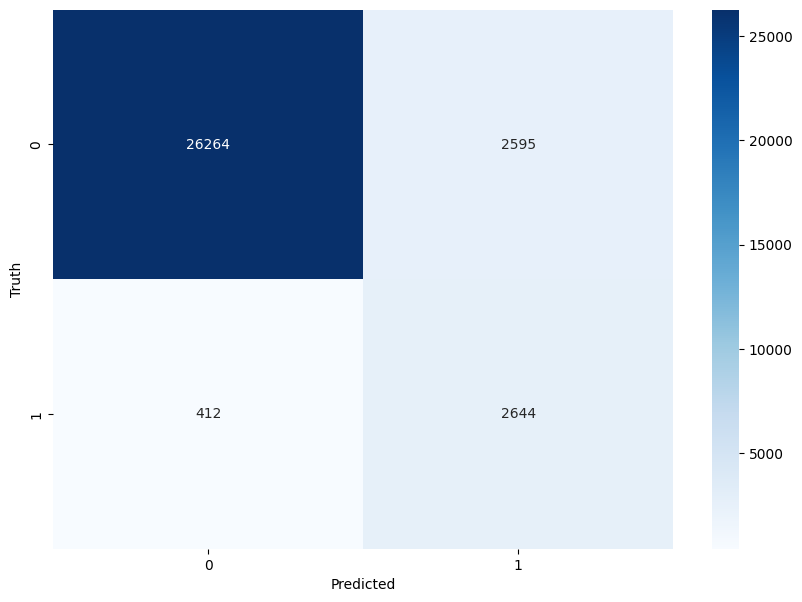

0.11294964028776978
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


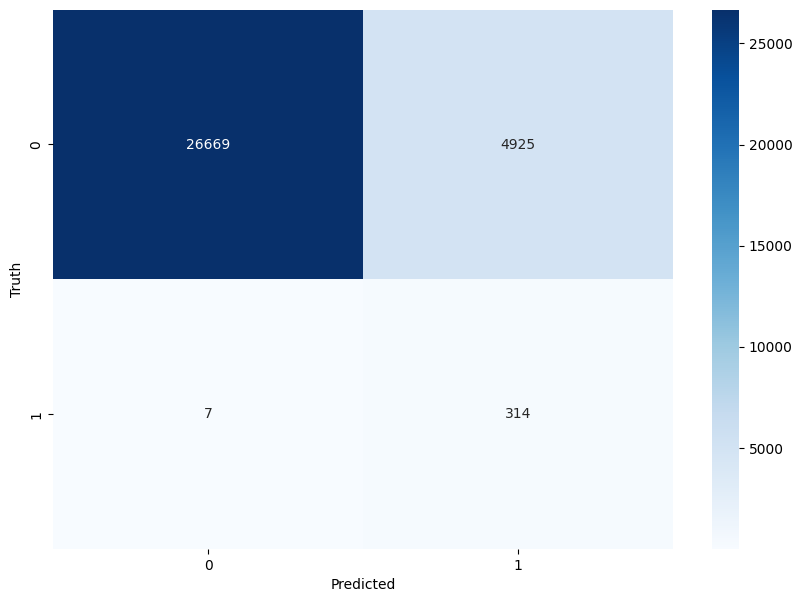

0.4627552487776819
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


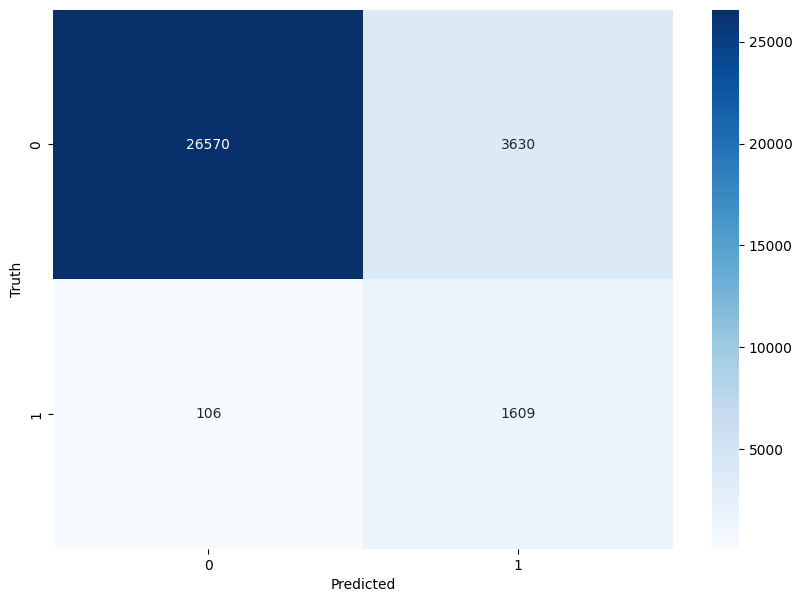

0.026350461133069828
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


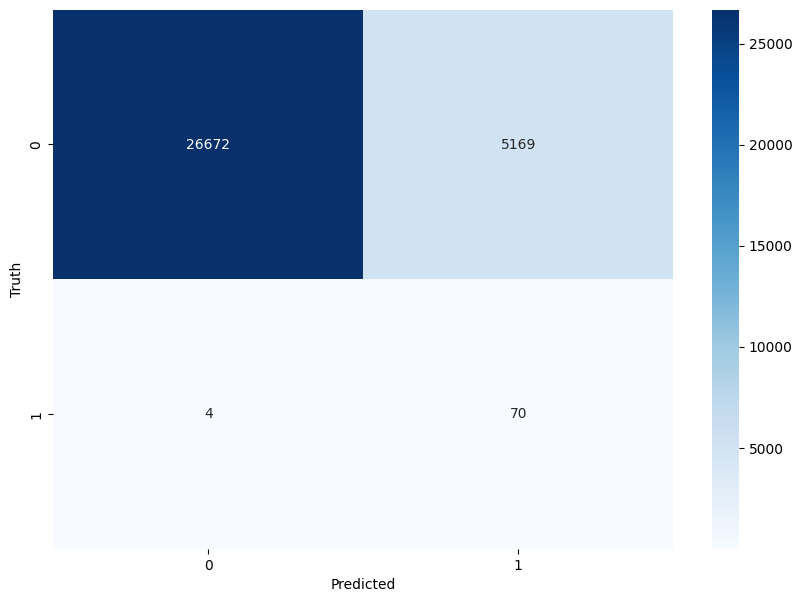

0.44301765650080255
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


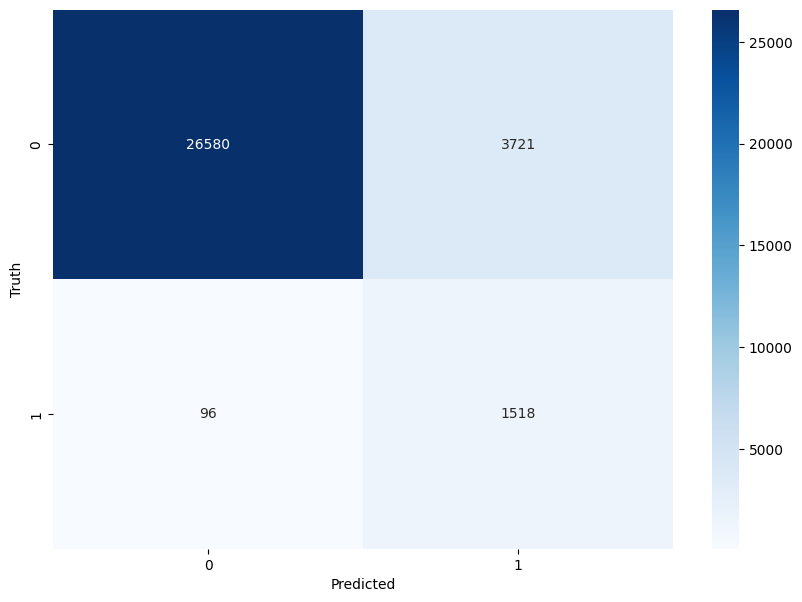

0.09795770829568046
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


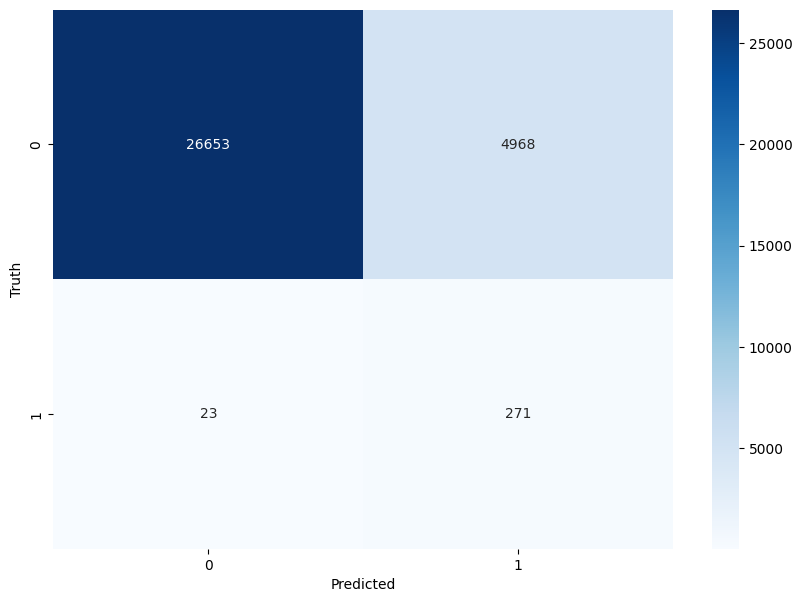

In [13]:
# Plot confusion matrix

for label in labels:
    # F1 score
    print(f1_score(y_test[label], y_pred))

    y_pred = model.predict(X_test_pad)
    y_pred = (y_pred > 0.5).astype(int)
    cm = confusion_matrix(y_test[label], y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.show()